4.0 Home Run Rates
==========
Attempting to predict home run rates based on batted ball type and direction

Libraries
----------

In [34]:
import os
import pandas as pd
import numpy as np

from pandas_gbq import read_gbq

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Data
----------

In [9]:
PROJECT_ID = 'ad-fantasy-baseball'
CREDENTIALS_PATH = os.path.join(os.pardir, './credentials/mlb-db-analysis-user.json')

In [10]:
params = {
    'game_type': 'R'
}

In [28]:
SQL = \
"""
SELECT
  t_bb.game_year AS game_year,
  t_players.mlb_id AS mlb_id,
  t_players.mlb_name AS mlb_name,
  t_players.fg_id AS fangraphs_id,
  t_bb.bb_events AS bb_events,
  t_bb.home_runs AS home_runs,
  ROUND(t_bb.home_runs / t_bb.bb_events, 3) AS hr_rate,
  (CASE WHEN t_bb.fly_events > 0 OR t_bb.line_events > 0
      THEN ROUND(t_bb.home_runs / (t_bb.fly_events + t_bb.line_events), 3)
    ELSE 0 END) AS hr_air_rate,
  (CASE WHEN t_bb.fly_events > 0 THEN ROUND(t_bb.fly_home_runs / t_bb.fly_events, 3)
    ELSE 0 END) AS fly_hr_rate,
  (CASE WHEN t_bb.line_events > 0 THEN ROUND(t_bb.line_home_runs / t_bb.line_events, 3)
    ELSE 0 END) AS line_hr_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.fly_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS fly_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.fly_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS fly_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.fly_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS fly_oppo_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.line_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS line_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.line_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS line_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.line_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS line_oppo_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.ground_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS ground_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.ground_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS ground_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.ground_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS ground_oppo_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.pop_pull_events / t_bb.bb_events, 3)
    ELSE 0 END) AS pop_pull_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.pop_center_events / t_bb.bb_events, 3)
    ELSE 0 END) AS pop_center_rate,
  (CASE WHEN t_bb.bb_events > 0 THEN ROUND(t_bb.pop_oppo_events / t_bb.bb_events, 3)
    ELSE 0 END) AS pop_oppo_rate,
  t_bb.fly_events AS fly_events,
  t_bb.line_events AS line_events,
  t_bb.ground_events AS ground_events,
  t_bb.pop_events AS pop_events,
  t_bb.fly_pull_events AS fly_pull_events,
  t_bb.fly_center_events AS fly_center_events,
  t_bb.fly_oppo_events AS fly_oppo_events,
  t_bb.line_pull_events AS line_pull_events,
  t_bb.line_center_events AS line_center_events,
  t_bb.line_oppo_events AS line_oppo_events,
  t_bb.ground_pull_events AS ground_pull_events,
  t_bb.ground_center_events AS ground_center_events,
  t_bb.ground_oppo_events AS ground_oppo_events,
  t_bb.pop_pull_events AS pop_pull_events,
  t_bb.pop_center_events AS pop_center_events,
  t_bb.pop_oppo_events AS pop_oppo_events
FROM
  (
    SELECT
      game_year,
      batter_id,
      COALESCE(SUM(bb_events), 0) AS bb_events,
      COALESCE(SUM(home_runs), 0) AS home_runs,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' THEN home_runs END), 0) AS fly_home_runs,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' THEN home_runs END), 0) AS line_home_runs,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' THEN bb_events END), 0) AS fly_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' THEN bb_events END), 0) AS line_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' THEN bb_events END), 0) AS ground_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' THEN bb_events END), 0) AS pop_events,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'pull' THEN bb_events END), 0) AS fly_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'center' THEN bb_events END), 0) AS fly_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'fly_ball' AND bb_direction = 'oppo' THEN bb_events END), 0) AS fly_oppo_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'pull' THEN bb_events END), 0) AS line_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'center' THEN bb_events END), 0) AS line_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'line_drive' AND bb_direction = 'oppo' THEN bb_events END), 0) AS line_oppo_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'pull' THEN bb_events END), 0) AS ground_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'center' THEN bb_events END), 0) AS ground_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'ground_ball' AND bb_direction = 'oppo' THEN bb_events END), 0) AS ground_oppo_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' AND bb_direction = 'pull' THEN bb_events END), 0) AS pop_pull_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' AND bb_direction = 'center' THEN bb_events END), 0) AS pop_center_events,
      COALESCE(SUM(CASE WHEN bb_type = 'popup' AND bb_direction = 'oppo' THEN bb_events END), 0) AS pop_oppo_events
    FROM
      (
        SELECT
          EXTRACT(YEAR FROM game_date) AS game_year,
          batter AS batter_id,
          bb_type AS bb_type,
          (CASE WHEN (spray_angle_est < -15 AND stand = 'R') OR (spray_angle_est > 15 AND stand = 'L') THEN 'pull'
                WHEN (spray_angle_est < -15 AND stand = 'L') OR (spray_angle_est > 15 AND stand = 'R') THEN 'oppo'
                WHEN spray_angle_est BETWEEN -15 AND 15 THEN 'center'
                ELSE 'no-angle'
          END) AS bb_direction,
          COUNT(*) AS bb_events,
          SUM(CASE WHEN events = 'home_run' THEN 1 END) AS home_runs
        FROM
          `ad-fantasy-baseball.core.statcast_extended`
        WHERE
          game_type = '{game_type}'
            AND type = 'X'
            AND NOT (events = 'field_out' AND REGEXP_CONTAINS(des, r'(?i)foul\sterritory'))
        GROUP BY 1, 2, 3, 4
      )
    GROUP BY 1, 2
    HAVING bb_events > 0
  ) t_bb
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name,
      fg_id
    FROM
      `ad-fantasy-baseball.core.players`
    GROUP BY 1, 2, 3
  ) t_players
    ON (t_bb.batter_id = t_players.mlb_id)
"""

In [29]:
sql_base = SQL.format(**params)
df_base = read_gbq(query=sql_base, dialect='standard', project_id=PROJECT_ID, private_key=CREDENTIALS_PATH)

df_copy = df_base.copy()

Data Preparation
----------

In [40]:
EVENT_THRESHOLD = 10
HR_THRESHOLD = 5
HR_RATE_THRESHOLD = 0

In [41]:
# Filters
_min_events = df_base['bb_events'] > EVENT_THRESHOLD
_min_hr = df_base['home_runs'] > HR_THRESHOLD
_min_hr_rate = df_base['hr_rate'] > HR_RATE_THRESHOLD
_threshold = _min_events & _min_hr & _min_hr_rate

In [42]:
df_threshold = df_base[_threshold]

In [43]:
df_threshold.head()

,game_year,mlb_id,mlb_name,fangraphs_id,bb_events,home_runs,hr_rate,hr_air_rate,fly_hr_rate,line_hr_rate,...,fly_oppo_events,line_pull_events,line_center_events,line_oppo_events,ground_pull_events,ground_center_events,ground_oppo_events,pop_pull_events,pop_center_events,pop_oppo_events
1206,2015,592620,Jarrett Parker,11624,28,6,0.214,0.353,0.667,0.182,...,1,1,8,2,9,1,1,0,0,0
1351,2015,608336,Joey Gallo,14128,49,6,0.122,0.207,0.308,0.125,...,1,12,3,1,16,3,0,0,1,0
1369,2017,606192,Teoscar Hernandez,13066,53,8,0.151,0.216,0.304,0.071,...,5,6,7,1,9,4,2,0,1,0
1398,2015,429667,Ryan Howard,2154,330,23,0.070,0.116,0.202,0.052,...,29,57,42,16,89,32,5,0,5,0
1400,2017,458675,Colby Rasmus,9893,75,9,0.120,0.191,0.333,0.043,...,6,12,11,0,18,6,2,0,2,0


Analysis
----------

In [35]:
sns.set(rc={'figure.figsize':(16,9)})

/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


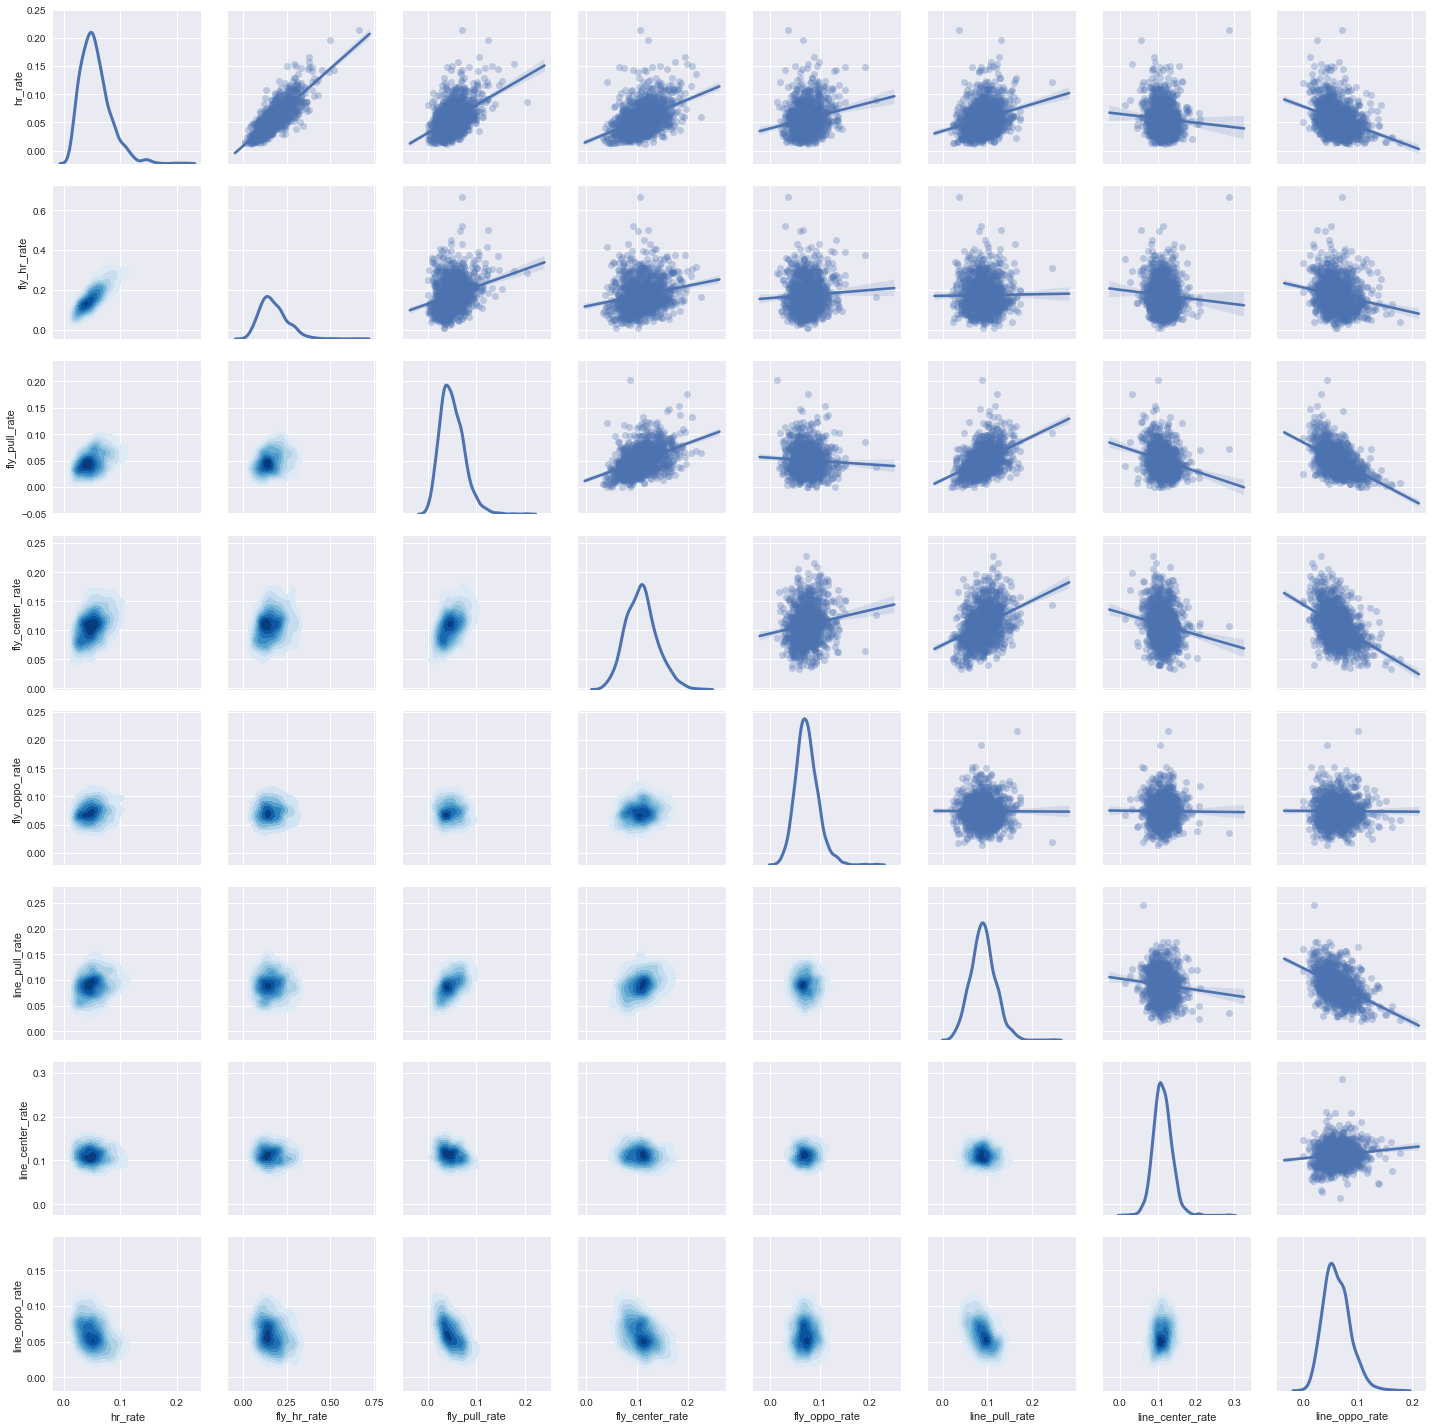

In [56]:
pair_columns = [
    'hr_rate',
    'fly_hr_rate',
    'fly_pull_rate',
    'fly_center_rate',
    'fly_oppo_rate',
    'line_pull_rate',
    'line_center_rate',
    'line_oppo_rate'
]
df_pair = df_threshold[pair_columns]

g = sns.PairGrid(df_pair)
g = g.map_upper(sns.regplot, scatter_kws={'alpha': 0.3})
g = g.map_lower(sns.kdeplot, cmap='Blues', shade=True, shade_lowest=False)
g = g.map_diag(sns.kdeplot, lw=3, legend=False)